In [1]:
from torch_geometric.data import Data, Batch, DataLoader
from torchvision.datasets import MNIST, CIFAR10, FashionMNIST
import torch

import matplotlib.pyplot as plt
import numpy as np
import time

# add directory above current directory to path
import sys
sys.path.insert(0, '..')

# Parameters

In [2]:
DATASET_NAME = "MNIST"
ADD_POSITION_TO_FEATURES = True
DESIRED_NODES = 300

## Load image dataset

In [3]:
print("Reading dataset...")

if DATASET_NAME == "MNIST":
    trainset = MNIST("../data", download=True, train=True)
    testset = MNIST("../data", download=True, train=False)
    
elif DATASET_NAME == "CIFAR10":
    trainset = CIFAR10("../data", download=True, train=True)
    testset = CIFAR10("../data", download=True, train=False)
    
elif DATASET_NAME == "FashionMNIST":
    trainset = FashionMNIST("../data", download=True, train=True)
    testset = FashionMNIST("../data", download=True, train=False)

print("Done.")

Reading dataset...
Done.


In [4]:
print(len(trainset))
print(len(testset))

60000
10000


torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])
(70000, 28, 28, 1)


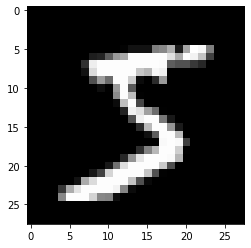

In [5]:
train_images = trainset.data
test_images = testset.data
print(train_images.shape)
print(test_images.shape)

images = np.concatenate((train_images, test_images))
images = np.reshape(images, (len(images), 28, 28, 1))
print(images.shape)

first_image = images[0]
plt.imshow(first_image, cmap='gray')
plt.show()

In [6]:
train_labels = trainset.targets
test_labels = testset.targets
labels = np.concatenate((train_labels, test_labels))
print(labels.shape)

(70000,)


## Test conversion on one img

In [7]:
from utils.img_to_graph import convert_img_to_superpixels_graph


x, edge_index, pos = convert_img_to_superpixels_graph(
    images[0],
    desired_nodes = DESIRED_NODES, 
    add_position_to_features=ADD_POSITION_TO_FEATURES
)
print(type(x))
print(x.shape)
print(edge_index.shape)
print(pos.shape)

<class 'numpy.ndarray'>
(196, 3)
(1120, 2)
(196, 2)


## Convert image dataset to superpixel graph dataset

In [8]:
import multiprocessing
from itertools import repeat

# apply patch to enable progress bar with multiprocessing, requires python 3.8+
# see https://stackoverflow.com/questions/57354700/starmap-combined-with-tqdm/57364423#57364423
from utils.img_to_graph import better_istarmap
multiprocessing.pool.Pool.istarmap = better_istarmap

# method for img -> superpixel_graph conversion
from utils.img_to_graph import convert_img_to_superpixels_graph

# tqdm for progress bar
from tqdm.auto import tqdm


print("Processing images into graphs...")
ptime = time.time()


x_list = []
edge_index_list = []
pos_list = []
slices = {
    "x": [0],
    "edge_index": [0],
    "pos": [0],
    "y": [0],
}


NUM_WORKERS = 6  # don't use too much or it will crash
with multiprocessing.Pool(NUM_WORKERS) as pool:
    args = list(zip(images, repeat(DESIRED_NODES), repeat(ADD_POSITION_TO_FEATURES)))
    for graph in tqdm(pool.istarmap(convert_img_to_superpixels_graph, args), total=len(args)):
        x, edge_index, pos = graph
        
        x = torch.as_tensor(x, dtype=torch.float32)
        edge_index = torch.as_tensor(edge_index, dtype=torch.long)
        pos = torch.as_tensor(pos, dtype=torch.float32)
        
        x_list.append(x)
        edge_index_list.append(edge_index)
        pos_list.append(pos)
        
        slices["x"].append(slices["x"][-1] + len(x))
        slices["edge_index"].append(slices["edge_index"][-1] + len(edge_index))
        slices["pos"].append(slices["pos"][-1] + len(pos))
        slices["y"].append(slices["y"][-1] + 1)


x_tensor = torch.cat(x_list, dim=0)
edge_index_tensor = torch.cat(edge_index_list, dim=0).T
pos_tensor = torch.cat(pos_list, dim=0)         
y_tensor = torch.as_tensor(labels, dtype=torch.long)

slices["x"] = torch.as_tensor(slices["x"], dtype=torch.long)
slices["edge_index"] = torch.as_tensor(slices["edge_index"], dtype=torch.long)
slices["pos"] = torch.as_tensor(slices["pos"], dtype=torch.long)
slices["y"] = torch.as_tensor(slices["y"], dtype=torch.long)

del x_list
del edge_index_list
del pos_list
            

ptime = time.time() - ptime
print(f"Took {ptime}s.")

Processing images into graphs...



Took 336.95216608047485s.


In [9]:
print(x_tensor.shape)
print(edge_index_tensor.shape)
print(pos_tensor.shape)
print(y_tensor.shape)

torch.Size([13720000, 3])
torch.Size([2, 78400000])
torch.Size([13720000, 2])
torch.Size([70000])


In [10]:
data = Data(x=x_tensor, edge_index=edge_index_tensor, pos=pos_tensor, y=y_tensor)
print(data)

Data(edge_index=[2, 78400000], pos=[13720000, 2], x=[13720000, 3], y=[70000])


## Save dataset in PyTorch Geometric format

In [21]:
import os

path = "../data/" + DATASET_NAME + "_superpixels_" + str(DESIRED_NODES) + "/" + "processed" + "/"
if not os.path.exists(path):
    os.makedirs(path)

torch.save((data, slices), path + "data.pt")